<a href="https://colab.research.google.com/github/cristinakuo/thesis-pre-research/blob/master/CTC_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
!git clone --recursive https://github.com/parlance/ctcdecode.git
!cd ctcdecode && pip install .

Cloning into 'ctcdecode'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 1059 (delta 5), reused 7 (delta 2), pack-reused 1047
Receiving objects: 100% (1059/1059), 759.79 KiB | 13.57 MiB/s, done.
Resolving deltas: 100% (508/508), done.
Submodule 'third_party/ThreadPool' (https://github.com/progschj/ThreadPool.git) registered for path 'third_party/ThreadPool'
Submodule 'third_party/kenlm' (https://github.com/kpu/kenlm.git) registered for path 'third_party/kenlm'
Cloning into '/content/ctcdecode/third_party/ThreadPool'...
remote: Enumerating objects: 82, done.        
remote: Total 82 (delta 0), reused 0 (delta 0), pack-reused 82        
Cloning into '/content/ctcdecode/third_party/kenlm'...
remote: Enumerating objects: 86, done.        
remote: Counting objects: 100% (86/86), done.        
remote: Compressing objects: 100% (60/60), done.        
remote: Total 13668 (delta 39), reused 53

In [4]:
import torch
import torch.nn as nn
import tqdm

print("CUDA available: ", torch.cuda.is_available())
dev = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(dev)  

# ------------------------------ Loading of raw data ------------------------------

# Load files: out_lab_fea_xx.pkl
# Saves the dictionary total_set in 3 files 
# that should contain train, dev and test data (in any order)

import pickle
import numpy as np

out_folder = '/content/gdrive/My Drive/Tesis/data/'
xi = 3 # Name of the 3 files (train, dev y test) 
xf = 6

total_set = dict()
for i in range(xi,xf):
    idf = str(i)
    out_file = 'out_lab_fea_' + idf + '.pkl'

    with open(out_folder+out_file,'rb') as f:
        total = pickle.load(f)
    total_set[total[5]] = total
    
data_name_train = total_set['train'][0]
data_end_index_train = total_set['train'][1]
fea_dict_train = total_set['train'][2]
lab_dict_train = total_set['train'][3]
data_set_train = total_set['train'][4]
todo_train = total_set['train'][5]

data_name_dev = total_set['dev'][0]
data_end_index_dev = total_set['dev'][1]
fea_dict_dev = total_set['dev'][2]
lab_dict_dev = total_set['dev'][3]
data_set_dev = total_set['dev'][4]
todo_dev = total_set['dev'][5]

data_name_test = total_set['test'][0]
data_end_index_test = total_set['test'][1]
fea_dict_test = total_set['test'][2]
lab_dict_test = total_set['test'][3]
data_set_test = total_set['test'][4]
todo_test = total_set['test'][5]

# Check number of phrases in transcripts
nr_phrases_train = len(data_name_train)
nr_phrases_test = len(data_name_test)

print('Nr of phrases (train): ', nr_phrases_train)
print('Nr of phrases (test): ', nr_phrases_test)

# Split into sequences according to end indices
train_sequences = np.split(data_set_train, data_end_index_train)[:-1] # Last item is empty
test_sequences = np.split(data_set_test, data_end_index_test)[:-1]

# Conver to tensor
train_sequences = [torch.from_numpy(seq) for seq in train_sequences]
test_sequences = [torch.from_numpy(seq) for seq in test_sequences]
print('Train: split data into {} phrases.'.format(len(train_sequences)))
print('Test: split data into {} phrases.'.format(len(test_sequences)))

vocab_list = ['aa','ae','ah','ao','aw','ax','ax-h','axr','ay','b','bcl','ch',
              'd','dcl','dh','dx','eh','el','em','en','eng','epi','er','ey',
              'f','g','gcl','h#','hh','hv','ih','ix','iy','jh','k','kcl','l',
              'm','n','ng','nx','ow','oy','p','pau','pcl','q','r','s','sh',
              't','tcl','th','uh','uw','ux','v','w','y','z','zh', '_']


CUDA available:  True
Nr of phrases (train):  3696
Nr of phrases (test):  192
Train: split data into 3696 phrases.
Test: split data into 192 phrases.


In [5]:
# Utils

def collapse_repeated(sequence):
  """
  Receives list of labels and remove the ones that are repeated consecutively
  
  E.g. [27 27 28 28 28] -> [27, 28]

  """

  if len(sequence) == 0:
    return sequence
  
  diff = np.diff(sequence).astype(np.bool)
  idx = np.insert(diff, 0, True)
  sequence_reduced = sequence[idx]

  return sequence_reduced

def print_distances(distances, token1Length, token2Length):
  for t1 in range(token1Length + 1):
      for t2 in range(token2Length + 1):
          print(int(distances[t1][t2]), end=" ")
      print()

def levenshtein_distance(token1, token2, debug=False):
  """
  Computes the Edit Distance between two sequences.
  """
  distances = numpy.zeros((len(token1) + 1, len(token2) + 1))

  for t1 in range(len(token1) + 1):
    distances[t1][0] = t1

  for t2 in range(len(token2) + 1):
    distances[0][t2] = t2
        
  a = 0
  b = 0
  c = 0
  
  for t1 in range(1, len(token1) + 1):
    for t2 in range(1, len(token2) + 1):
      if (token1[t1-1] == token2[t2-1]):
          distances[t1][t2] = distances[t1 - 1][t2 - 1]
      else:
          a = distances[t1][t2 - 1]
          b = distances[t1 - 1][t2]
          c = distances[t1 - 1][t2 - 1]             
          min_dist = min((a,b,c))

          distances[t1][t2] = min_dist + 1

  if debug:
    print_distances(distances, len(token1), len(token2))
    
  return distances[len(token1)][len(token2)]


In [15]:
# Decoding
from dataclasses import dataclass
from typing import List
from ctcdecode import CTCBeamDecoder

# *********************************************************************** #
#                           Decoding
# *********************************************************************** #
@dataclass 
class Decoder():
  blank_label: int
  remove_blanks: bool = True
  collapse_repeated: bool = True

  def decode(self, sequences, sequence_lens=None, *args, **kwargs):
    pass

  def _post_process(self, decoded_seq):
    if self.collapse_repeated:
      decoded_seq = collapse_repeated(decoded_seq.cpu())
      decoded_seq = decoded_seq.to(dev)
      
    if self.remove_blanks:
      decoded_seq = decoded_seq[decoded_seq != self.blank_label]

    return decoded_seq

@dataclass
class GreedyDecoder(Decoder):

  def decode(self, sequences, sequence_lens=None, *args, **kwargs):
    """
    For each timestemp, takes the label with maximum probability.
    Optionally removes consecutively repeated labels and blank labels.
  
    :param sequences: torch tensor [batch, sequence len, number of classes]
    :param sequence_lens: list of sequence lengths for each sequence in batch
    :return: list of decoded sequences (different lengths).
    """

    decoded_sequences = []
    for sequence, seq_len in zip(sequences, sequence_lens):
      seq = sequence[:seq_len]  # Remove pads
      decoded_seq = torch.argmax(seq, dim=1)
    
      decoded_seq = self._post_process(decoded_seq)

      decoded_sequences.append(decoded_seq)

    return decoded_sequences

@dataclass
class BeamSearchDecoder(Decoder):
  labels: List = None
  model_path: str = None
  alpha: float = 0.0
  beta: float = 0.0 
  cutoff_top_n: int = 40
  cutoff_prob: float = 1.0
  beam_width: int = 3
  num_processes: int = 4
  blank_id: int = 0
  log_probs_input: bool = True

  def __post_init__(self):
    self._decoder = CTCBeamDecoder(labels=self.labels,
                                   model_path=self.model_path,
                                   alpha=self.alpha,
                                   beta=self.beta,
                                   cutoff_top_n=self.cutoff_top_n,
                                   cutoff_prob=self.cutoff_prob,
                                   beam_width=self.beam_width,
                                   num_processes=self.num_processes,
                                   blank_id=self.blank_id, # This should be the index of the CTC blank token # Maybe it should be blank_label - 1?
                                   log_probs_input=self.log_probs_input)
    
  def decode(self, sequences, sequence_lens=None, *args, **kwargs):
    """
    :param sequences: [batch, number of timesteps, number of classes]
    :param sequence_lens:
    """

    beam_result, beam_scores, timesteps, out_seq_len = self._decoder.decode(sequences, seq_lens=sequence_lens)
    # beam_result [batchsize, n_beams, n_timesteps]
    # TODO: convert to decoded output and return
    decoded_sequences = []

    for sequence,out_len in zip(beam_result, out_seq_len):
      beam_number = 0
      decoded_sequence = sequence[beam_number][:out_len[beam_number]]
      decoded_sequence = decoded_sequence.to(device)
      
      decoded_sequence = self._post_process(decoded_sequence)

      decoded_sequences.append(decoded_sequence)

    return decoded_sequences


def label_error_rate(predicted_sequences, target_sequences, predicted_lens, target_lens, debug=False):
  total_distance = 0
  
  nr_batches = len(predicted_sequences)

  for i in range(nr_batches):
    pred_seq = predicted_sequences[i]
    target_seq = target_sequences[i]
    predicted_len = predicted_lens[i]
    target_len = target_lens[i]

    pred_seq = pred_seq[:predicted_len]
    target_seq = target_seq[:target_len]

    dist = levenshtein_distance(pred_seq, target_seq)
    total_distance += dist

  target_total_len = sum(target_lens)
  label_err_rate = float(total_distance)/float(target_total_len)*100  # Although LER it's not a real percentage, as it could be > %100
  
  if debug:
    print("Total distance ", total_distance)
    print("Target total len ", target_total_len)

  return label_err_rate

In [16]:
import numpy
import tqdm

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
import torch.optim as optim
from torch.nn import CTCLoss, LogSoftmax
from torch.nn.functional import log_softmax

FEATURE_DIM = 13 
NR_PHONEMES = 61
BLANK_LABEL = 61  # 0 to 60 are used
PADDING_VALUE = -1 


# *********************************************************************** #
#                           Hyper parameters
# *********************************************************************** #

BATCH_SIZE = 3
NUM_EPOCHS = 20
learning_rate = 0.01
momentum = 0.9
hidden_size = 100
layer_size = 2 # Number of layers

BEAM_WIDTH = 3 # Only used if decoding with Beam search

decoder = GreedyDecoder(blank_label=BLANK_LABEL)
decoder = BeamSearchDecoder(labels=vocab_list, blank_label=BLANK_LABEL, 
                            beam_width=BEAM_WIDTH, log_probs_input=True,
                            blank_id=BLANK_LABEL)

# *********************************************************************** #
#                             Dataset
# *********************************************************************** #

class SpeechDataset(Dataset):
  def __init__(self, list_of_sequences):
    self.data = list_of_sequences
    self.n_samples = len(list_of_sequences)
    self.seq_lens = [len(seq) for seq in list_of_sequences]
    self.n_frames = sum(self.seq_lens)

  def __getitem__(self, index):
    return self.data[index]

  def __len__(self):
    return self.n_samples


train_dataset = SpeechDataset(train_sequences)
test_dataset = SpeechDataset(test_sequences)

print("Train Samples: {}".format(len(train_dataset)))
print("Train frames: ", train_dataset.n_frames)
print("Test Samples: {}".format(len(test_dataset)))
print("Test frames: ", test_dataset.n_frames)
print()


def collate_timit(batch):
    """
    batch: list of numpy arrays of different lengths
    """
    # Get length for each sequence
    input_lens = [sequence.shape[0] for sequence in batch]
    
    # Pad sequences to max length in batch
    batch_padded = pad_sequence(batch, batch_first=True, padding_value=PADDING_VALUE)
    batch_padded = torch.as_tensor(batch_padded)
    
    # Get batched input
    x_batch = batch_padded[:,:,:-1]
    
    # Obtain targets
    y_batch = [seq[:,-1] for seq in batch]

    # Remove repeated consecutive labels in target sequences: (E.g. [27 27 28 28 28 61] -> [27 28 61])
    # NOTE: This is done to make targets shorter than input, so that nn.CTCLoss doesn't yield infinite values
    y_batch_reduced = []
    target_lens = []
    for y_seq in y_batch: # Loop over each sequence
      y_seq_reduced = collapse_repeated(y_seq)
      y_batch_reduced.append(y_seq_reduced)
      target_lens.append(len(y_seq_reduced))

    # Pad target sequences
    y_batch_padded = pad_sequence(y_batch_reduced, batch_first=True, padding_value=PADDING_VALUE)
    
    y_batch = torch.as_tensor(y_batch_padded)
    
    return x_batch, y_batch, input_lens, target_lens


# *********************************************************************** #
#                           Model
# *********************************************************************** #

class BLSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, nr_layers, output_size):
    super(BLSTMModel, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.nr_layers = nr_layers

    # Hidden layer
    # batch_first=True means input/output tensors to be of shape
    # (batch_dim, seq_dim, feature_dim)
    self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.nr_layers, 
                        batch_first=True, bidirectional=True, bias=True)
    
    # Output Layer
    # Input is hidden_size*2 because it has a bidirectional LSTM as previous layer
    self.fc = torch.nn.Linear(self.hidden_size*2, self.output_size, bias=True)

    self.log_softmax = LogSoftmax(dim=2)

  def forward(self, x, seq_lens): # x has shape [batch_size, max_seq_len, nr_coef]

    x_packed = pack_padded_sequence(x, lengths=seq_lens, batch_first=True, enforce_sorted=False) # x_packed.data has shape [nr_batch_frames, nr_coefs]
    out_lstm, _ = self.lstm(x_packed) # out_lstm.data has shape [nr_batch_frames, nr_coefs]

    out_lstm_padded, out_lens = pad_packed_sequence(out_lstm, batch_first=True, padding_value=PADDING_VALUE) # [batch_size, sequences_max_len, nr_coefs]

    out = self.fc(out_lstm_padded) # [batch_size, sequences_max_len, nr_classes] 
    # CTCLoss will ignore the padding values as sequences lengths from input and target are passed to it

    
    return out, out_lens


# *********************************************************************** #
#                        Train & Test functions
# *********************************************************************** #

def train_model(model, data_loader):

  model.train()
  
  epoch_loss = 0

  for batch_idx, (input_data, target_data, seq_lens, target_lens) in enumerate(tqdm.notebook.tqdm((data_loader))): 
    # Save to device
    input_data = input_data.to(torch.float)
    target_data = target_data.to(torch.long)
    input_data, target_data = input_data.to(device), target_data.to(device)
    
    optimizer.zero_grad() # Clear grads before doing backward
    
    # Forward pass
    model_out, out_lens = model(input_data, seq_lens) # [batch_size, seq_len, classes]

    # Prepare CTC inputs
    model_out = log_softmax(model_out, dim=2) # [batch_size, sequences_max_len, nr_classes]
    model_out_permuted = model_out.permute(1,0,2) # [seq_len, batch_size, classes] 
    input_lens = out_lens.to(torch.long)
    target_lens = torch.tensor(target_lens, dtype=torch.long)

    batch_loss = cost_function(model_out_permuted.cpu(), target_data.cpu(), input_lens.cpu(), target_lens.cpu())
    epoch_loss += batch_loss.item()
    
    # Backward pass
    batch_loss.backward()
    optimizer.step()

  epoch_loss = epoch_loss/len(data_loader.dataset) # Divide by number of sequences

  return epoch_loss

def test_model(model, data_loader):

  # This will notify all the layers that it's eval mode, that way, 
  # batchnorm or dropout layers will work in eval mode instead of training mode.
  model.eval()

  total_loss = 0
  nr_correct_frames = 0
  total_frames = 0
  label_err_rates = []
  
  # no_grad impacts the autograd engine and deactivate it. 
  # It will reduce memory usage and speed up computations 
  # and it won’t be able to backprop (which is not desired 
  # in an eval script).
  with torch.no_grad(): 
    for batch_idx, (input_data, target_data, seq_lens, target_lens) in enumerate(tqdm.notebook.tqdm((data_loader))):
      input_data = input_data.to(torch.float)
      target_data = target_data.to(torch.long)
      input_data, target_data = input_data.to(device), target_data.to(device)  
      
      model_out, out_lens = model(input_data, seq_lens)

      # Prepare CTC inputs
      model_out = log_softmax(model_out, dim=2) # [batch_size, sequences_max_len, nr_classes]
      model_out_permuted = model_out.permute(1,0,2) # [seq_len, batch_size, classes] 
      input_lens = out_lens.to(torch.long)
      target_lens = torch.tensor(target_lens, dtype=torch.long) 

      # Compute loss
      batch_loss = cost_function(model_out_permuted.cpu(), target_data.cpu(), input_lens.cpu(), target_lens.cpu())
      total_loss += batch_loss.item()

      # Predict
      predictions = decoder.decode(model_out, input_lens)
      
      # Get error
      label_err_rate = label_error_rate(predictions, target_data, input_lens, target_lens)
      label_err_rates.append(label_err_rate)

  average_loss = total_loss/len(data_loader.dataset) # Divide by number sequences
  avg_label_err_rate = sum(label_err_rates)/len(label_err_rates)

  print(label_err_rates)
  print(avg_label_err_rate)

  return average_loss, avg_label_err_rate


# **************************** Instantiate model & train ******************************** #

input_size = FEATURE_DIM
output_size = NR_PHONEMES + 1  # Number of phonemes + 1 for blank label

model = BLSTMModel(input_size, hidden_size, layer_size, output_size)
model = model.to(device)

cost_function = nn.CTCLoss(blank=BLANK_LABEL, zero_infinity=False)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

print("Created BLSTM model with parameters:")
print("Input size: ", input_size)
print("Hidden size: ", hidden_size)
print("Layer size: ", layer_size)
print("Output size: ", output_size)
print("Batch size: ", BATCH_SIZE)

losses = []
label_error_rates = []

for epoch in range(NUM_EPOCHS):
  print("Epoch nr: ", epoch + 1)

  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_timit)
  train_loss = train_model(model, train_loader)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_timit)
  test_loss, test_label_error_rate = test_model(model, test_loader)
  losses.append(test_loss)
  label_error_rates.append(test_label_error_rate)
  print("---- Training results ----")
  print("Loss:", train_loss)
  print("---- Test results ----")
  print("Loss:", test_loss)
  print("Label error rate:", test_label_error_rate)
  print()

Train Samples: 3696
Train frames:  1124823
Test Samples: 192
Test frames:  57919

Created BLSTM model with parameters:
Input size:  13
Hidden size:  100
Layer size:  2
Output size:  62
Batch size:  3
Epoch nr:  1



[100.0, 100.0, 97.43589743589743, 96.875, 100.0, 98.52941176470588, 98.79518072289156, 98.91304347826086, 97.05882352941177, 96.5909090909091, 98.98989898989899, 99.01960784313727, 98.91304347826086, 98.73417721518987, 98.9010989010989, 97.77777777777777, 98.09523809523809, 98.18181818181819, 96.29629629629629, 98.75, 98.86363636363636, 98.21428571428571, 100.0, 97.19626168224299, 97.2972972972973, 96.96969696969697, 98.9795918367347, 96.62921348314607, 99.0909090909091, 97.5, 97.97979797979798, 98.24561403508771, 98.29059829059828, 97.27272727272728, 96.93877551020408, 97.87234042553192, 98.26086956521739, 98.31932773109243, 98.27586206896551, 99.04761904761905, 100.0, 97.77777777777777, 99.21875, 99.09909909909909, 97.61904761904762, 97.79411764705883, 98.07692307692307, 97.65625, 98.4251968503937, 97.85714285714285, 98.11320754716981, 98.31932773109243, 98.15950920245399, 98.125, 98.75776397515527, 98.64864864864865, 98.02631578947368, 98.0, 98.125, 98.25581395348837, 98.2352941176


[92.98245614035088, 92.15686274509804, 84.61538461538461, 90.625, 92.0, 91.17647058823529, 91.56626506024097, 94.56521739130434, 89.70588235294117, 89.77272727272727, 85.85858585858585, 92.15686274509804, 90.21739130434783, 91.13924050632912, 90.10989010989012, 86.66666666666667, 88.57142857142857, 90.9090909090909, 93.82716049382715, 92.5, 95.45454545454545, 90.17857142857143, 91.2621359223301, 92.5233644859813, 88.28828828828829, 88.88888888888889, 89.79591836734694, 87.64044943820225, 91.81818181818183, 94.16666666666667, 87.87878787878788, 89.47368421052632, 92.3076923076923, 92.72727272727272, 92.85714285714286, 87.94326241134752, 89.56521739130436, 89.07563025210085, 86.20689655172413, 92.38095238095238, 84.16666666666667, 94.07407407407408, 96.875, 91.8918918918919, 91.26984126984127, 89.70588235294117, 92.3076923076923, 91.40625, 90.5511811023622, 87.14285714285714, 93.08176100628931, 90.75630252100841, 89.57055214723927, 92.5, 91.92546583850931, 89.86486486486487, 93.42105263


[75.43859649122807, 76.47058823529412, 58.97435897435898, 62.5, 65.33333333333333, 58.82352941176471, 63.85542168674698, 67.3913043478261, 63.23529411764706, 64.77272727272727, 64.64646464646465, 62.745098039215684, 69.56521739130434, 72.15189873417721, 63.73626373626373, 64.44444444444444, 67.61904761904762, 67.27272727272727, 67.90123456790124, 72.5, 70.45454545454545, 58.92857142857143, 60.19417475728155, 65.42056074766354, 68.46846846846847, 64.64646464646465, 69.38775510204081, 61.79775280898876, 64.54545454545455, 70.0, 72.72727272727273, 58.77192982456141, 74.35897435897436, 65.45454545454545, 63.26530612244898, 65.24822695035462, 66.95652173913044, 68.0672268907563, 63.793103448275865, 64.76190476190476, 65.0, 64.44444444444444, 75.78125, 68.46846846846847, 64.28571428571429, 64.70588235294117, 65.38461538461539, 66.40625, 70.07874015748031, 61.42857142857143, 68.55345911949685, 74.78991596638656, 65.03067484662577, 65.0, 68.94409937888199, 68.91891891891892, 62.5, 70.66666666


[63.1578947368421, 58.82352941176471, 48.717948717948715, 42.1875, 53.333333333333336, 48.529411764705884, 48.19277108433735, 42.391304347826086, 50.0, 43.18181818181818, 52.52525252525253, 50.98039215686274, 48.91304347826087, 46.835443037974684, 42.857142857142854, 44.44444444444444, 43.80952380952381, 40.909090909090914, 50.617283950617285, 47.5, 51.13636363636363, 42.857142857142854, 41.74757281553398, 47.66355140186916, 52.25225225225225, 42.42424242424242, 41.83673469387755, 38.20224719101123, 49.09090909090909, 50.0, 49.494949494949495, 41.228070175438596, 52.991452991452995, 43.63636363636363, 34.69387755102041, 47.5177304964539, 47.82608695652174, 48.739495798319325, 49.137931034482754, 49.523809523809526, 46.666666666666664, 45.18518518518518, 53.90625, 40.54054054054054, 45.23809523809524, 51.470588235294116, 46.15384615384615, 45.3125, 53.54330708661418, 46.42857142857143, 49.056603773584904, 46.21848739495798, 49.693251533742334, 49.375, 48.4472049689441, 54.0540540540540


[59.64912280701754, 50.98039215686274, 50.0, 40.625, 40.0, 42.64705882352941, 51.80722891566265, 42.391304347826086, 50.0, 31.818181818181817, 52.52525252525253, 42.15686274509804, 47.82608695652174, 45.56962025316456, 35.16483516483517, 44.44444444444444, 40.0, 40.0, 38.2716049382716, 46.25, 44.31818181818182, 32.142857142857146, 39.80582524271845, 45.794392523364486, 46.846846846846844, 36.36363636363637, 39.795918367346935, 31.46067415730337, 43.63636363636363, 46.666666666666664, 43.43434343434344, 35.96491228070175, 47.863247863247864, 40.0, 28.57142857142857, 39.71631205673759, 46.95652173913044, 46.21848739495798, 46.55172413793103, 40.0, 41.66666666666667, 37.77777777777778, 54.6875, 38.73873873873874, 41.269841269841265, 44.85294117647059, 43.269230769230774, 42.96875, 50.39370078740157, 39.285714285714285, 40.25157232704403, 45.378151260504204, 49.693251533742334, 46.875, 46.58385093167702, 45.27027027027027, 41.44736842105263, 43.333333333333336, 42.5, 44.76744186046512, 42


[61.40350877192983, 49.01960784313725, 42.30769230769231, 34.375, 38.666666666666664, 32.35294117647059, 48.19277108433735, 41.30434782608695, 38.23529411764706, 34.090909090909086, 46.464646464646464, 38.23529411764706, 48.91304347826087, 34.177215189873415, 37.362637362637365, 41.11111111111111, 35.23809523809524, 34.54545454545455, 37.03703703703704, 38.75, 45.45454545454545, 33.035714285714285, 35.92233009708738, 39.25233644859813, 42.34234234234234, 30.303030303030305, 42.857142857142854, 39.325842696629216, 41.81818181818181, 38.333333333333336, 45.45454545454545, 39.473684210526315, 44.44444444444444, 40.0, 29.591836734693878, 34.751773049645394, 44.34782608695652, 42.016806722689076, 41.37931034482759, 40.0, 36.666666666666664, 39.25925925925926, 50.78125, 37.83783783783784, 35.714285714285715, 39.705882352941174, 39.42307692307692, 40.625, 45.66929133858268, 36.42857142857142, 37.735849056603776, 38.655462184873954, 46.62576687116564, 45.0, 45.962732919254655, 43.918918918918


[61.40350877192983, 45.09803921568628, 43.58974358974359, 37.5, 33.33333333333333, 32.35294117647059, 43.373493975903614, 40.21739130434783, 42.64705882352941, 32.95454545454545, 42.42424242424242, 33.33333333333333, 45.65217391304348, 37.9746835443038, 40.65934065934066, 40.0, 33.33333333333333, 35.45454545454545, 37.03703703703704, 38.75, 44.31818181818182, 33.035714285714285, 35.92233009708738, 36.44859813084112, 40.54054054054054, 31.313131313131315, 40.816326530612244, 39.325842696629216, 41.81818181818181, 39.166666666666664, 44.44444444444444, 33.33333333333333, 47.008547008547005, 37.27272727272727, 28.57142857142857, 37.5886524822695, 40.869565217391305, 37.81512605042017, 42.241379310344826, 33.33333333333333, 35.833333333333336, 36.2962962962963, 50.78125, 36.93693693693694, 34.12698412698413, 40.44117647058824, 38.46153846153847, 39.84375, 41.732283464566926, 37.142857142857146, 33.9622641509434, 40.33613445378151, 47.239263803680984, 42.5, 44.72049689440994, 41.2162162162


[57.89473684210527, 43.13725490196079, 37.17948717948718, 37.5, 34.66666666666667, 27.941176470588236, 45.78313253012048, 42.391304347826086, 38.23529411764706, 28.40909090909091, 41.41414141414141, 35.294117647058826, 45.65217391304348, 32.91139240506329, 37.362637362637365, 42.22222222222222, 32.38095238095238, 38.18181818181819, 34.5679012345679, 40.0, 42.04545454545455, 31.25, 33.980582524271846, 40.18691588785047, 37.83783783783784, 29.292929292929294, 38.775510204081634, 30.337078651685395, 32.72727272727273, 36.666666666666664, 40.4040404040404, 35.08771929824561, 42.73504273504273, 36.36363636363637, 28.57142857142857, 36.87943262411347, 41.73913043478261, 38.655462184873954, 42.241379310344826, 37.142857142857146, 29.166666666666668, 38.51851851851852, 48.4375, 34.234234234234236, 34.12698412698413, 35.294117647058826, 38.46153846153847, 30.46875, 41.732283464566926, 30.0, 36.477987421383645, 38.655462184873954, 48.466257668711656, 40.0, 42.857142857142854, 43.91891891891892,


[56.14035087719298, 35.294117647058826, 37.17948717948718, 35.9375, 29.333333333333332, 27.941176470588236, 44.57831325301205, 32.608695652173914, 38.23529411764706, 31.818181818181817, 37.37373737373738, 33.33333333333333, 44.565217391304344, 27.848101265822784, 34.065934065934066, 41.11111111111111, 31.428571428571427, 31.818181818181817, 38.2716049382716, 38.75, 38.63636363636363, 31.25, 33.00970873786408, 39.25233644859813, 38.73873873873874, 27.27272727272727, 32.6530612244898, 33.70786516853933, 30.0, 35.0, 37.37373737373738, 31.57894736842105, 40.17094017094017, 35.45454545454545, 28.57142857142857, 39.71631205673759, 36.52173913043478, 36.97478991596639, 35.3448275862069, 30.476190476190478, 25.833333333333336, 39.25925925925926, 46.09375, 32.432432432432435, 30.952380952380953, 36.029411764705884, 35.57692307692308, 31.25, 42.51968503937008, 30.714285714285715, 34.59119496855346, 33.61344537815126, 42.331288343558285, 41.25, 42.857142857142854, 39.86486486486486, 35.526315789


[52.63157894736842, 43.13725490196079, 35.8974358974359, 34.375, 28.000000000000004, 23.52941176470588, 37.34939759036144, 35.869565217391305, 36.76470588235294, 28.40909090909091, 39.39393939393939, 34.31372549019608, 42.391304347826086, 29.11392405063291, 37.362637362637365, 36.666666666666664, 35.23809523809524, 38.18181818181819, 34.5679012345679, 32.5, 37.5, 31.25, 33.980582524271846, 36.44859813084112, 34.234234234234236, 28.28282828282828, 30.612244897959183, 26.96629213483146, 30.0, 34.166666666666664, 38.38383838383838, 30.701754385964914, 40.17094017094017, 35.45454545454545, 26.53061224489796, 38.297872340425535, 36.52173913043478, 38.655462184873954, 38.793103448275865, 30.476190476190478, 28.333333333333332, 34.074074074074076, 43.75, 29.72972972972973, 29.365079365079367, 32.35294117647059, 34.61538461538461, 28.125, 42.51968503937008, 27.857142857142858, 36.477987421383645, 35.294117647058826, 39.87730061349693, 37.5, 42.2360248447205, 39.189189189189186, 35.52631578947


[45.614035087719294, 39.21568627450981, 38.46153846153847, 35.9375, 29.333333333333332, 25.0, 36.144578313253014, 38.04347826086957, 35.294117647058826, 31.818181818181817, 38.38383838383838, 34.31372549019608, 42.391304347826086, 30.37974683544304, 34.065934065934066, 41.11111111111111, 32.38095238095238, 36.36363636363637, 29.629629629629626, 31.25, 40.909090909090914, 33.035714285714285, 31.06796116504854, 34.57943925233645, 34.234234234234236, 26.262626262626267, 33.6734693877551, 30.337078651685395, 30.909090909090907, 33.33333333333333, 41.41414141414141, 29.82456140350877, 42.73504273504273, 31.818181818181817, 30.612244897959183, 32.62411347517731, 33.91304347826087, 37.81512605042017, 37.93103448275862, 33.33333333333333, 25.0, 39.25925925925926, 42.1875, 31.53153153153153, 26.984126984126984, 33.088235294117645, 36.53846153846153, 29.6875, 40.94488188976378, 29.28571428571429, 33.9622641509434, 35.294117647058826, 40.49079754601227, 38.75, 41.61490683229814, 37.8378378378378


[49.122807017543856, 39.21568627450981, 38.46153846153847, 32.8125, 32.0, 29.411764705882355, 33.734939759036145, 32.608695652173914, 30.88235294117647, 29.545454545454547, 37.37373737373738, 36.27450980392157, 43.47826086956522, 21.518987341772153, 35.16483516483517, 37.77777777777778, 30.476190476190478, 35.45454545454545, 30.864197530864196, 37.5, 39.77272727272727, 28.57142857142857, 33.00970873786408, 33.64485981308411, 37.83783783783784, 29.292929292929294, 31.63265306122449, 31.46067415730337, 28.18181818181818, 35.0, 35.35353535353536, 30.701754385964914, 38.46153846153847, 30.909090909090907, 27.55102040816326, 35.46099290780142, 34.78260869565217, 35.294117647058826, 38.793103448275865, 36.19047619047619, 22.5, 36.2962962962963, 39.0625, 31.53153153153153, 30.158730158730158, 30.14705882352941, 36.53846153846153, 29.6875, 40.15748031496063, 27.857142857142858, 35.22012578616352, 32.773109243697476, 40.49079754601227, 39.375, 40.37267080745342, 39.189189189189186, 33.55263157


[47.368421052631575, 45.09803921568628, 33.33333333333333, 35.9375, 26.666666666666668, 23.52941176470588, 33.734939759036145, 33.69565217391305, 33.82352941176471, 29.545454545454547, 37.37373737373738, 31.372549019607842, 38.04347826086957, 25.31645569620253, 32.967032967032964, 37.77777777777778, 31.428571428571427, 35.45454545454545, 32.098765432098766, 31.25, 43.18181818181818, 32.142857142857146, 26.21359223300971, 30.8411214953271, 36.03603603603604, 27.27272727272727, 33.6734693877551, 31.46067415730337, 25.454545454545453, 35.0, 40.4040404040404, 29.82456140350877, 41.02564102564102, 30.0, 29.591836734693878, 33.33333333333333, 37.391304347826086, 36.97478991596639, 37.93103448275862, 31.428571428571427, 23.333333333333332, 41.48148148148148, 44.53125, 31.53153153153153, 26.984126984126984, 28.676470588235293, 29.807692307692307, 31.25, 42.51968503937008, 29.28571428571429, 34.59119496855346, 32.773109243697476, 38.65030674846626, 36.25, 43.47826086956522, 38.513513513513516,


[47.368421052631575, 37.254901960784316, 34.61538461538461, 34.375, 28.000000000000004, 19.11764705882353, 34.93975903614458, 30.434782608695656, 39.705882352941174, 35.22727272727273, 40.4040404040404, 34.31372549019608, 41.30434782608695, 22.78481012658228, 34.065934065934066, 37.77777777777778, 28.57142857142857, 34.54545454545455, 25.925925925925924, 36.25, 35.22727272727273, 31.25, 27.184466019417474, 33.64485981308411, 36.93693693693694, 28.28282828282828, 31.63265306122449, 29.213483146067414, 28.18181818181818, 39.166666666666664, 38.38383838383838, 30.701754385964914, 35.04273504273504, 34.54545454545455, 25.510204081632654, 31.20567375886525, 35.65217391304348, 36.97478991596639, 37.93103448275862, 36.19047619047619, 25.0, 38.51851851851852, 41.40625, 27.027027027027028, 24.6031746031746, 27.941176470588236, 36.53846153846153, 27.34375, 36.22047244094488, 27.142857142857142, 33.33333333333333, 33.61344537815126, 38.036809815950924, 36.25, 41.61490683229814, 38.51351351351351


[50.877192982456144, 35.294117647058826, 38.46153846153847, 35.9375, 26.666666666666668, 22.058823529411764, 32.53012048192771, 31.521739130434785, 42.64705882352941, 31.818181818181817, 33.33333333333333, 34.31372549019608, 44.565217391304344, 30.37974683544304, 35.16483516483517, 35.55555555555556, 34.285714285714285, 33.63636363636363, 27.160493827160494, 33.75, 34.090909090909086, 30.357142857142854, 28.155339805825243, 34.57943925233645, 35.13513513513514, 27.27272727272727, 30.612244897959183, 31.46067415730337, 25.454545454545453, 35.0, 41.41414141414141, 28.07017543859649, 39.31623931623932, 31.818181818181817, 24.489795918367346, 32.62411347517731, 33.04347826086956, 37.81512605042017, 37.06896551724138, 29.523809523809526, 25.833333333333336, 39.25925925925926, 39.84375, 27.927927927927925, 28.57142857142857, 28.676470588235293, 28.846153846153843, 25.78125, 40.15748031496063, 27.857142857142858, 33.9622641509434, 31.092436974789916, 41.104294478527606, 36.875, 39.7515527950


[43.859649122807014, 29.411764705882355, 35.8974358974359, 32.8125, 30.666666666666664, 20.588235294117645, 33.734939759036145, 32.608695652173914, 38.23529411764706, 30.681818181818183, 39.39393939393939, 30.392156862745097, 42.391304347826086, 27.848101265822784, 32.967032967032964, 40.0, 29.523809523809526, 34.54545454545455, 24.691358024691358, 30.0, 40.909090909090914, 30.357142857142854, 25.24271844660194, 35.51401869158878, 33.33333333333333, 28.28282828282828, 27.55102040816326, 29.213483146067414, 20.909090909090907, 35.0, 40.4040404040404, 29.82456140350877, 35.8974358974359, 31.818181818181817, 27.55102040816326, 29.078014184397162, 37.391304347826086, 37.81512605042017, 38.793103448275865, 32.38095238095238, 25.833333333333336, 41.48148148148148, 39.0625, 26.126126126126124, 31.746031746031743, 27.941176470588236, 33.65384615384615, 28.125, 40.15748031496063, 27.857142857142858, 32.075471698113205, 34.45378151260504, 39.87730061349693, 35.0, 38.50931677018634, 39.864864864


[36.84210526315789, 33.33333333333333, 30.76923076923077, 31.25, 28.000000000000004, 23.52941176470588, 31.32530120481928, 32.608695652173914, 35.294117647058826, 32.95454545454545, 36.36363636363637, 27.450980392156865, 41.30434782608695, 26.582278481012654, 30.76923076923077, 41.11111111111111, 29.523809523809526, 36.36363636363637, 24.691358024691358, 37.5, 36.36363636363637, 26.785714285714285, 22.330097087378643, 33.64485981308411, 36.93693693693694, 27.27272727272727, 31.63265306122449, 30.337078651685395, 23.636363636363637, 33.33333333333333, 39.39393939393939, 27.192982456140353, 41.88034188034188, 31.818181818181817, 29.591836734693878, 32.62411347517731, 37.391304347826086, 36.97478991596639, 34.48275862068966, 31.428571428571427, 25.0, 43.7037037037037, 37.5, 27.027027027027028, 30.158730158730158, 27.941176470588236, 30.76923076923077, 28.125, 42.51968503937008, 25.71428571428571, 34.59119496855346, 33.61344537815126, 39.263803680981596, 36.25, 38.50931677018634, 36.48648


[49.122807017543856, 35.294117647058826, 33.33333333333333, 34.375, 29.333333333333332, 20.588235294117645, 28.915662650602407, 30.434782608695656, 33.82352941176471, 31.818181818181817, 38.38383838383838, 33.33333333333333, 40.21739130434783, 30.37974683544304, 32.967032967032964, 37.77777777777778, 29.523809523809526, 32.72727272727273, 27.160493827160494, 37.5, 30.681818181818183, 25.892857142857146, 29.126213592233007, 33.64485981308411, 34.234234234234236, 24.242424242424242, 24.489795918367346, 26.96629213483146, 27.27272727272727, 30.833333333333336, 41.41414141414141, 27.192982456140353, 37.60683760683761, 31.818181818181817, 27.55102040816326, 34.751773049645394, 34.78260869565217, 35.294117647058826, 37.93103448275862, 35.23809523809524, 20.833333333333336, 40.74074074074074, 40.625, 28.82882882882883, 30.952380952380953, 28.676470588235293, 34.61538461538461, 25.78125, 37.00787401574803, 23.57142857142857, 31.446540880503143, 34.45378151260504, 37.423312883435585, 36.25, 34


[45.614035087719294, 33.33333333333333, 30.76923076923077, 35.9375, 25.333333333333336, 20.588235294117645, 33.734939759036145, 30.434782608695656, 32.35294117647059, 36.36363636363637, 35.35353535353536, 33.33333333333333, 40.21739130434783, 32.91139240506329, 28.57142857142857, 41.11111111111111, 31.428571428571427, 35.45454545454545, 23.456790123456788, 31.25, 30.681818181818183, 25.0, 29.126213592233007, 34.57943925233645, 36.03603603603604, 23.232323232323232, 23.46938775510204, 25.842696629213485, 19.090909090909093, 34.166666666666664, 35.35353535353536, 24.561403508771928, 38.46153846153847, 31.818181818181817, 22.448979591836736, 32.62411347517731, 34.78260869565217, 34.45378151260504, 40.51724137931034, 36.19047619047619, 22.5, 35.55555555555556, 38.28125, 26.126126126126124, 27.77777777777778, 27.205882352941174, 31.73076923076923, 27.34375, 35.43307086614173, 27.142857142857142, 28.930817610062892, 33.61344537815126, 38.036809815950924, 36.875, 36.024844720496894, 35.81081


[47.368421052631575, 29.411764705882355, 34.61538461538461, 32.8125, 22.666666666666664, 20.588235294117645, 31.32530120481928, 31.521739130434785, 36.76470588235294, 30.681818181818183, 37.37373737373738, 27.450980392156865, 43.47826086956522, 34.177215189873415, 34.065934065934066, 37.77777777777778, 27.61904761904762, 36.36363636363637, 23.456790123456788, 32.5, 37.5, 28.57142857142857, 27.184466019417474, 31.775700934579437, 34.234234234234236, 22.22222222222222, 27.55102040816326, 28.08988764044944, 22.727272727272727, 33.33333333333333, 39.39393939393939, 29.82456140350877, 38.46153846153847, 31.818181818181817, 30.612244897959183, 29.78723404255319, 36.52173913043478, 33.61344537815126, 33.62068965517241, 34.285714285714285, 23.333333333333332, 41.48148148148148, 39.84375, 27.027027027027028, 29.365079365079367, 29.411764705882355, 31.73076923076923, 28.90625, 36.22047244094488, 23.57142857142857, 31.446540880503143, 36.134453781512605, 35.58282208588957, 33.75, 37.888198757763

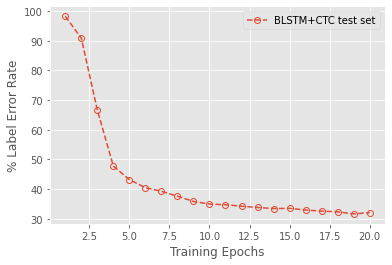

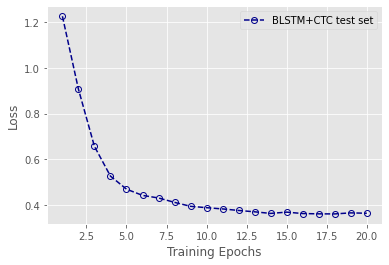

In [17]:
import datetime
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# ------------ Label error rates ----------------
root_path = '/content/gdrive/My Drive/Tesis/models/CTC/'
date_of_training = str(datetime.date.today())
suffix = ''
filename = date_of_training + '_' + str(NUM_EPOCHS) + 'epochs' + suffix


fig, ax = plt.subplots()
epochs = np.arange(1, NUM_EPOCHS+1)
ax.plot(epochs, label_error_rates, '--o', markerfacecolor='None', label='BLSTM+CTC test set')
ax.set(xlabel='Training Epochs', ylabel='% Label Error Rate')

learning_curve_filepath = root_path +'LER_with_seq_len' + filename + '.png'
plt.legend()
fig.savefig(learning_curve_filepath)
plt.show()

# ------------ Losses ----------------

fig, ax = plt.subplots()
ax.plot(epochs, losses, '--o', markerfacecolor='None', color='darkblue', label='BLSTM+CTC test set')
ax.set(xlabel='Training Epochs', ylabel='Loss')

loss_curve_filepath = root_path +'loss_with_seq_len' + filename + '.png'
plt.legend()
fig.savefig(loss_curve_filepath)
plt.show()